# Why does the Clusterdl algorithm was developped?

There are several different approaches to clustering, including hierarchical methods, centroid methods, distribution-based methods, and density-based methods. However, these methods may not be appropriate for all types of data. Centroid-based methods are not effective with irregularly shaped clusters, density-based methods may not perform well with large datasets due to high computational cost, and distribution-based methods may not work well if the data does not follow certain probabilistic assumptions. Additionally, these methods require the use of hyperparameters, which can significantly impact the final result. The density-based methods typically require fewer hyperparameters but may take longer to run. To address these limitations and provide a more flexible and reliable method for clustering large mineral datasets with multiple material types and complex cluster distributions, a novel algorithm was developed. This algorithm combines dimension reduction, density estimation, and graph-theory techniques to identify clusters of any shape and distribution. This approach was inspired by the Clusterdv algorithm but is designed to handle larger datasets with thousands of samples. Unlike Clusterdv, which is not suitable for large datasets due to high computational cost, the novel algorithm is able to efficiently process large datasets and offer a deterministic and reliable solution for identifying material types in mineral datasets.

# What is the Clusterdl algorithm doing?

The algorithm is designed to find clusters in large mineral datasets in order to identify material types using given features. It does this by first reducing the dimensions of the data using a dimension reduction technique (UMAP, TRIMAP, PACMAP...). This step is not detailled in this code and the user can choose its own methodology. Next, it computes the Kernel Density Estimation on the reduced 2D space and extracts contours of similar density. These contours are used to identify potential cluster center candidates, which are then transformed into nodes and used to create a graph. The novel algorithm uses the minimum bottleneck algorithm, a concept from graph theory, to compute the maximum minimum density path between two potential cluster centers. This maximum minimum flow is used to calculate a separability index for each candidate, which helps to identify the true cluster centers. Once the true cluster centers have been identified from the candidates, the algorithm assigns each point in the dataset to the cluster center with the highest density using a simple rule: points are assigned to the cluster of their closest neighbor with higher density. Finally, the result of the clustering algorithm is plotted.

In [1]:
# Import the librairies
import scipy.stats as st
from scipy.spatial import KDTree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
def create_grid(x, y, border_fraction=0, num_points=100):
    """
    Generate a 2D grid of points over the range of values in the `x` and `y` arrays, with a border of a certain fraction around the edges.
    
    Parameters:
        x (numpy array): 1D array of x values.
        y (numpy array): 1D array of y values.
        border_fraction (float): Fraction of the range of x and y values to add as a border on each side. Default is 0.
        num_points (int): Number of points in each dimension of the grid. Default is 100.
    
    Returns:
        xx (numpy array): 2D array of x values for the grid.
        yy (numpy array): 2D array of y values for the grid.
    """
    
    # Calculate the borders
    deltaX = (np.max(x) - np.min(x)) * border_fraction
    deltaY = (np.max(y) - np.min(y)) * border_fraction
    xmin = np.min(x) - deltaX
    xmax = np.max(x) + deltaX
    ymin = np.min(y) - deltaY
    ymax = np.max(y) + deltaY
    
    # Create the meshgrid
    xx, yy = np.mgrid[xmin:xmax:num_points*1j, ymin:ymax:num_points*1j]
    
    # Return the grid components
    return xx, yy

In [3]:
def evaluate_kde(x, y, xx, yy, bw_method):
    """
    Calculate a Gaussian kernel density estimate (KDE) at each point in a 2D grid.
    
    Parameters:
        x (numpy array): 1D array of x values.
        y (numpy array): 1D array of y values.
        xx (numpy array): 2D array of x values for the grid.
        yy (numpy array): 2D array of y values for the grid.
        bw_method (str): Method for estimating the bandwidth of the Gaussian kernel. Default is 'scott'.
    
    Returns:
        f (numpy array): 2D array of KDE values at each point in the grid.
        kernel (gaussian_kde object): Gaussian KDE object with the calculated KDE.
    """
    
    # Create the positions array and the values array
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    
    # Create the Gaussian KDE object
    kernel = st.gaussian_kde(values, bw_method=bw_method)
    
    # Evaluate the KDE at each point in the grid and reshape the result
    f = np.reshape(kernel(positions).T, xx.shape)
    
    # Return the Gaussian KDE object and the array of the KDE values
    return f, kernel

In [4]:
def create_contours(x, y, xx, yy, f, levels):
    """
    Generate contours and extract the boundary of the contours.
    
    Parameters:
        x (numpy array): 1D array of x values.
        y (numpy array): 1D array of y values.
        xx (numpy array): 2D array of x values for the grid.
        yy (numpy array): 2D array of y values for the grid.
        f (numpy array): 2D array of values at each point in the grid.
        levels (list): Number of contour levels.
    
    Returns:
        polygon (list): List of polygons representing the contour boundaries. Each polygon is a list of points (x, y coordinates).
    """
    
    # Create the contours
    fig, ax = plt.subplots(figsize=(10,10))
    cset = ax.contour(xx, yy, f, levels = levels)
    
    # Extract the contour boundaries and plot them
    polygon = []
    for j in range(len(cset.allsegs)):
        for ii, seg in enumerate(cset.allsegs[j]):
            polygon.append([seg[:,0], seg[:,1]])
            plt.plot(seg[:,0], seg[:,1], '.-', color='black')
    
    # Return the polygon contours
    return polygon

In [5]:
def compute_polygon_centers(polygon, kernel):
    """
    Compute the centers and densities of a list of polygons using a kernel density estimate (KDE).
    
    Parameters:
        polygon (list): List of polygons. Each polygon is a list of points (x, y coordinates).
        kernel (scipy.stats.kde.gaussian_kde): KDE object used to evaluate the density at each point.
    
    Returns:
        polygon_center (list): List of points (x, y coordinates) representing the centers of the polygons.
        polygon_center_density (list): List of densities at the corresponding points in the `polygon_center` list.
    """
    
    polygon_center = []
    polygon_center_density = []
    
    # Iterate over the polygons
    for poly_nb in range(len(polygon)):
        # Calculate the mean x and y coordinates for the polygon
        x_mean = np.mean(polygon[poly_nb][0])
        y_mean = np.mean(polygon[poly_nb][1])
        
        # Append the center of the polygon to the polygon_center list
        polygon_center.append([x_mean, y_mean])
        
        # Calculate the density at the center of the polygon using the KDE object
        density = kernel.evaluate(np.array([x_mean, y_mean]))
        
        # Append the density to the polygon_center_density list
        polygon_center_density.append(density)
    
    # Return the polygon centers and their respective densities
    return polygon_center, polygon_center_density

In [6]:
def get_kde_point(point, kernel):
    """
    Calculate the density at a point using a kernel density estimate (KDE).
    
    Parameters:
        point (tuple): Point to calculate the density at (x, y coordinates).
        kernel (scipy.stats.kde.gaussian_kde): KDE object used to evaluate the density at each point.
    
    Returns:
        density (float): Density at the specified point.
    """
    
    # Return the density value
    return float(kernel.evaluate(np.array([point[0], point[1]])))

In [7]:
def get_kde_segment(pointA, pointB, eta, kernel):
    """
    Find the minimum density along a line segment using a kernel density estimate (KDE).
    
    Parameters:
        pointA (tuple): Starting point of the line segment (x, y coordinates).
        pointB (tuple): End point of the line segment (x, y coordinates).
        eta (int): Number of points to evaluate along the line segment.
        kernel (scipy.stats.kde.gaussian_kde): KDE object used to evaluate the density at each point.
    
    Returns:
        minimum (float): Minimum density along the line segment.
    """
    
    minimum = np.inf
    
    # Evaluate the KDE at a number of points along the linesegment segment
    for i in range(eta+1):
        current = get_kde_point((1-(i/eta))*pointA + (i/eta)*pointB, kernel)
        
        # Update the minimum density if necessary
        if current < minimum:
            minimum = current
            
    # Return the minimum density
    return minimum

In [8]:
def compute_polygon_weights(polygon, polygon_center, eta, kernel):
    """
    Calculate the weights of the edges between polygons using a kernel density estimate (KDE).
    
    Parameters:
        polygon (list): List of polygons. Each polygon is a list of points (x, y coordinates).
        polygon_center (list): List of points (x, y coordinates) representing the centers of the polygons.
        eta (int): Number of points to evaluate along the line segment.
        kernel (scipy.stats.kde.gaussian_kde): KDE object used to evaluate the density at each point.
    
    Returns:
        adj_mat (numpy array): Adjacency matrix with dimensions equal to the number of polygons. All elements are initialized to 1.
        weight (numpy array): Weight matrix with the same dimensions as the adjacency matrix. Each element represents the minimum density along the line segment connecting the corresponding polygons.
    """
    
    # Initialize the adjacency matrix and weight matrix
    adj_mat = np.ones((len(polygon), len(polygon)))
    weight = np.zeros((len(polygon), len(polygon)))
    
    # Iterate over the elements in the weight matrix
    for i in range(len(polygon)):
        for j in range(len(polygon)):
            if i != j:
                # Calculate the minimum density along the line segment connecting the centers of the two polygons
                weight[i][j] = get_kde_segment(np.array(polygon_center[i]), np.array(polygon_center[j]), eta, kernel)
    
    # Return the adjacency and weight matrixes
    return adj_mat, weight

In [9]:
def path_max(G, s, t, current_depth):
    """
    Find the maximum weight of a path between two nodes in a graph.
    
    Parameters:
        G (networkx.Graph): Graph to search for the path in.
        s (int): Source node.
        t (int): Target node.
        current_depth (int): Current depth of the recursion.
    
    Returns:
        maximum_weight (float): Maximum weight of a path between the source and target nodes.
    """
    
    # If the graph has only one edge, return the weight of that edge
    if len(list(G.edges.data())) == 1:
        return list(G.edges.data())[0][2]['weight']
    
    # If the source and target nodes are the same, return 0
    if s == t:
        return 0
    
    # If the target node is a neighbor of the source node, return the weight of the edge connecting the two nodes
    if t in list(G.neighbors(s)):
        return G[s][t]['weight']
    
    # If either the source node or the target node has no neighbors, return 0
    if len(list(G.neighbors(s))) == 0 or len(list(G.neighbors(t))) == 0:
        return 0
    
    # Compute the median weight of the edges in the graph
    weight = np.array([edge[2]['weight'] for edge in list(G.edges.data())])
    median = np.median(weight)                                                      
    
    # Create a new graph containing only the edges with weight greater than or equal to the median
    G_k = nx.Graph()
    G_k.add_nodes_from(G)
    for edge in list(G.edges.data()):
        if edge[2]['weight'] >= median:
            G_k.add_edge(edge[0], edge[1], weight=edge[2]['weight'])
    
    # If the target node is in the connected component of the source node in G_k, search for the maximum weight path within that component
    if t in list(nx.node_connected_component(G_k, s)):
        return path_b(G_k.subgraph(nx.node_connected_component(G_k, s)), s, t, current_depth)
    
    # Otherwise, create a new graph by adding a node for each connected component in G_k
    else:
        S = [G_k.subgraph(c) for c in nx.connected_components(G_k)]
        G_bar_k = nx.Graph()
        x = None
        y = None
        for u, G_u in enumerate(S):
            G_bar_k.add_node(u)
            if s in list(G_u.nodes()):
                x = u
            if t in list(G_u.nodes()):
                y = u
            for v, G_v in enumerate(S):
                if u != v:
                    # Find the maximum weight edge connecting the two connected components
                    assigned = False
                    maximum_weight = -np.inf
                    maximum_link = [None, None]
                    for node_u in list(G_u.nodes()):
                        for node_v in list(G_v.nodes()):
                            if node_v in list(G.neighbors(node_u)):
                                w = G[node_u][node_v]['weight']
                                if w > maximum_weight:
                                    assigned = True
                                    maximum_weight = w
                                    maximum_link[0] = node_u
                                    maximum_link[1] = node_v
                    # Add the edge to G_bar_k if it exists
                    if assigned:
                        G_bar_k.add_edge(u, v, weight=maximum_weight)
        
        # Increment the current depth of the recursion
        current_depth += 1
        
        # Check if the maximum weight path has already been computed
        if (current_depth, x, y) in solution:
            return solution[(current_depth, x, y)]
                                                
        # If the maximum weight path has not been computed, search for it in G_bar_k
        else: 
            res = path_max(G_bar_k, x, y, current_depth)
            # Store the result in the solution dictionary
            solution[(current_depth, x, y)] = res
            
            #Return the result obtained
            return res           

In [10]:
def calculate_maximum_flow(G, polygon_center, kernel):
    """
    Calculates the maximum flow between all pairs of points in polygon_center using the graph G.

    Parameters:
        G (networkx.Graph): The graph to use for calculating the maximum flow.
        polygon_center (list of tuples): A list of points in the form (x, y) to calculate the maximum flow between.
        kernel (scipy.stats.kde.gaussian_kde): KDE object used to evaluate the density at each point.

    Returns:
        (list): A list of maximum flow values for each pair of points in polygon_center.
    """
    
    # Calculate the density at each point in polygon_center using the KDE object
    dens_list = [get_kde_point(point, kernel) for point in polygon_center]
    # Create a dataframe from the density list with a 'density' column
    dens_df = pd.DataFrame(dens_list, columns=['density'])
    # Sort the densities in descending order and get the indices of the sorted list
    dens_df = dens_df.sort_values(by=['density'], ascending=False)
    # Get the values of the sorted densities as a numpy array
    dens_list = dens_df.to_numpy()
    # Get the indices of the sorted densities as a list
    ind_cand = dens_df.index
    
    # Initialize the list to store the maximum flow values
    max_flow = []
    
    # Iterate through the sorted list of indices
    for ind, i in enumerate(ind_cand):
        # Initialize the maximum flow to -infinity
        maximum = -np.inf
        
        # Calculate the maximum flow between i and all indices preceding it in the list
        for j in ind_cand[:ind]:
            current_depth = 0
            flow = path_max(G, i, j, current_depth)
            # Update the maximum flow if a larger value is found
            if flow > maximum:
                maximum = flow
        
        # If the maximum flow is -infinity, either set it to 0 (if i is the first element in the list) or infinity (if i is not the first element)
        if maximum == -np.inf:
            if ind == 0:
                max_flow.append(0)
            else:
                max_flow.append(np.inf)
        # Otherwise, append the maximum flow to the list
        else:
            max_flow.append(maximum)
    
    # Return the list of maximum flow values, the list of density values and the density dataframe
    return max_flow, list(np.ravel(dens_list)), dens_df

In [11]:
def get_well_separated_points(max_flow, dens_list, polygon_center, dens_df):
    """
    Calculate the separability of each point in polygon_center and return a list of points that are well-separated.
    
    A point is considered well-separated if its separability is greater than 0. The separability of a point is defined as 1 - (max_flow / density), where max_flow is the maximum flow between the point and all of the preceding points in the list, and density is the density of the point.

    Parameters:
        max_flow (list): A list of maximum flow values for each pair of points in polygon_center.
        dens_list (list): A list of densities at each point in polygon_center.
        polygon_center (list): A list of points in the form (x, y) to calculate the separability of.

    Returns:  
        (list): A list of points in polygon_center that are well-separated.
    """
    
    # Calculate the separability of each point as 1 - (max_flow / density)
    separability = np.array([1-(max_flow[i]/(1*dens_list[i])) for i in range(len(max_flow))])
    dens_df['separability'] = separability

    # Filter the dataframe to include only rows where the separability is greater than 0
    well_separated = dens_df[dens_df['separability'] > 0]

    # Return the list of well-separated points and the associated indexes
    return well_separated, dens_df.loc[dens_df['separability']>0,:].index.to_numpy()

In [12]:
def find_closest_point(point, points):
    """
    Find the point in the given list of points that is closest to the given point using a k-d tree.
    
    Parameters:
        point (list or numpy array): The point for which to find the closest point in the list.
        points (list or numpy array): The list of points to search for the closest point.
        
    Returns:
        (list): The coordinates of the point in the list that is closest to the given point.
    """
    
    # Build a k-d tree from the list of points
    tree = KDTree(points)
    
    # Find the index of the point in the k-d tree that is closest to the given point
    # The query method returns both the distance between the two points and the index of the closest point in the tree
    dist, idx = tree.query(point)
    
    # Return the coordinates of the closest point by indexing into the points list
    return points[idx], idx, dist

In [13]:
def assign_points_to_centers(xy, polygon_center, ind_selection, kernel):
    """
    Assign each point in the 'xy' array to the nearest point in the 'polygon_center' array,
    using a k-d tree and taking into account the density of each point as determined by the 'get_kde_point' function.
    
    Parameters:
        xy (numpy array): An array of points to be assigned to centers.
        polygon_center (numpy array): An array of center points to which the points in 'xy' will be assigned.
        ind_selection (list): A list of indices of the elements in 'polygon_center' to consider as center points.
        kernel (function, optional): A function that returns the density of a point.
    
    Returns:
        assignment (numpy array): An array of assignments, with each element representing the index of the center point to which the corresponding point in 'xy' is assigned.
    """
    
    # Calculate the density of each point in the xy array using the get_kde_point function
    density = []        
    for point in xy:
        density.append(get_kde_point(point, kernel))
        
    # Convert the density list into a dataframe and sort it by density in descending order
    df_density = pd.DataFrame(density, columns=['density'])
    df_density = df_density.sort_values(by=['density'], ascending=False)
    
    # Extract the indices of the sorted dataframe and convert them to a NumPy array
    index_den_total = df_density.index.to_numpy()
    
    # Initialize the res array as a list containing the elements at the indices in the ind_selection list from the polygon_center list
    res = [polygon_center[i] for i in ind_selection]
    
    # Build a k-d tree from the xy array
    tree = KDTree(xy)
    
    # Initialize the assignment array as an array of zeros with the same length as the xy array
    assignment = np.zeros(len(xy))
    
    # Iterate over the indices in the index_den_total array
    for i, ind in enumerate(index_den_total):
        # If i is equal to 0, set the element at index ind in the assignment array to the index of the closest point in the res array to the point at index ind in the xy array
        if i == 0:
            assignment[ind] = find_closest_point(xy[ind], res)[1]
        # If i is not equal to 0, find the closest point in the res array and in a list containing the points at the indices in the index_den_total array up to but not including i
        else:
            res_center = find_closest_point(xy[ind], res)
            res_normal = find_closest_point(xy[ind], np.array([xy[k] for k in index_den_total[:i]]))
            # If the distance between the point at index ind in the xy array and the closest point in the res array is less than the distance between the point at index ind in the xy array and the closest point in the list of points up to but not including i, set the element at index ind in the assignment array to the index of the closest point in the res array
            if res_center[2] < res_normal[2]:
                assignment[ind] = res_center[1]
            # If the distance between the point at index ind in the xy array and the closest point in the res array is not less than the distance between the point at index ind in the xy array and the closest point in the list of points up to but not including i, set the element at index ind in the assignment array to the value of the element in the assignment array at the index in index_den_total up to but not including i
            else:
                assignment[ind]= assignment[index_den_total[:i][res_normal[1]]]
    
    # Return the assignment array
    return assignment

In [14]:
def plot_assignment(x, y, assignment):
    """
    This function plots the points in x and y with colors corresponding to their assignment.
    
    Parameters:
        x (numpy array): 1D array of x-coordinates of the points.
        y (numpy array): 1D array of y-coordinates of the points.
        assignment (numpy array): 1D array of assignments for each point.
    """
    
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(10,10))
    
    # Plot the points using matplotlib's scatter function
    ax.scatter(x, y, c=assignment, s=10, cmap='Set1')
    
    # Display the plot
    plt.show()

In [15]:
def cluster_dl(x, y, levels=20, eta=20, bw_method='scott', num_points=100, border_fraction=0.1):
    """
    Compute the cluster assignment for a set of points using the flow-based method.
    
    Parameters:
        x (numpy array): 1D array of x values.
        y (numpy array): 1D array of y values.
        border_fraction (float): Fraction of the range of x and y values to add as a border on each side. Default is 10%.
        num_points (int): Number of points in each dimension of the grid. Default is 100.
        eta (int): Number of points to evaluate along the line segment.

    Returns:
        assignment (numpy array): 1D array of cluster assignments for each point.
    """
    
    # Create a grid for evaluating the KDE
    xx, yy = create_grid(x, y, border_fraction = border_fraction, num_points = num_points)

    # Evaluate the KDE on the grid
    f, kernel = evaluate_kde(x, y, xx, yy, bw_method = bw_method)

    # Extract the contour lines from the contour plot
    polygon = create_contours(x, y, xx, yy, f, levels = levels)

    # Compute the centers and densities of the polygons
    polygon_center, polygon_center_density = compute_polygon_centers(polygon, kernel = kernel)

    # Compute the adjacency matrix and weights of the polygons
    adj_mat, weight = compute_polygon_weights(polygon, polygon_center, eta = eta, kernel = kernel)

    # Create a graph from the adjacency matrix and weights
    G = nx.Graph(weight)

    # Calculate the maximum flow between the polygons
    max_flow, dens_list, cand = calculate_maximum_flow(G, polygon_center, kernel = kernel)

    # Identify the well-separated points in the graph
    well_separated, ind_selection = get_well_separated_points(max_flow, dens_list, polygon_center, cand)
    
    # Create a new figure
    plt.figure(figsize=(10,10))

    # Iterate over the selected polygons' centers and plot each one as a large, black asterisk
    for center in [polygon_center[i] for i in ind_selection]:
        plt.scatter(center[0], center[1], s = 300, marker = '*', color = 'black')

    # Iterate over the polygons and plot each one in black
    for poly_nb in range(len(polygon)):
        plt.plot(polygon[poly_nb][0], polygon[poly_nb][1], color = 'black')
    
    # Create an array combining x and y
    xy = np.array([[x[i], y[i]] for i in range(len(x))])
    
    # Build a k-d tree from the points
    tree = KDTree(xy)
    
    # Assign a cluster center to each of the data point
    assignment = assign_points_to_centers(xy, polygon_center, ind_selection, kernel)

    # Plot the assignments of the data points to the well-separated contours
    plot_assignment(x, y, assignment)
    
    # Return the assignment array
    return assignment

In [16]:
# Create a test dataset
from sklearn import datasets
xy = pd.read_csv('xy.csv').to_numpy()
x, y = xy[:, 0], xy[:, 1]

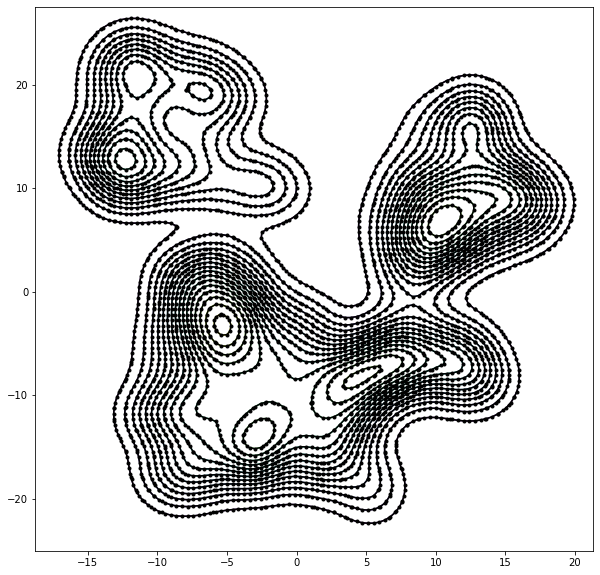

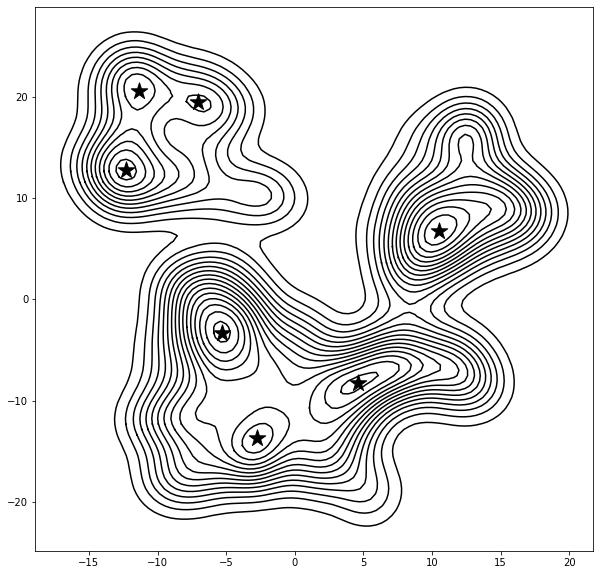

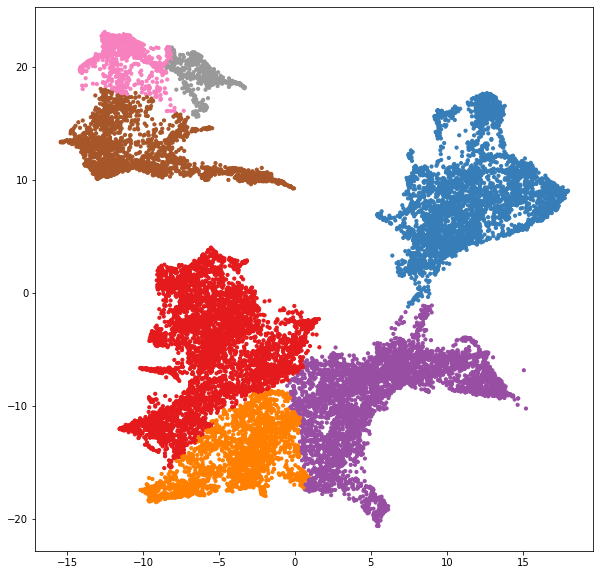

In [17]:
# Test the code
assignment = cluster_dl(x, y, levels = 20, eta = 20, bw_method = 'scott', num_points = 100, border_fraction = 0.1)